In [90]:
from __future__ import print_function
import six
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import optimize
try:
    import seaborn as sns
    sns.set_style('white')
except ImportError:
    pass

from visual_behavior import utilities as vbu
from visual_behavior import plotting as vbp

In [89]:
%widescreen

In [1]:
def plot_psychometric(
        x,
        y,
        initial_guess=(0.1, 1, 0.5, 0.5),
        alpha=1,
        xval_jitter=0,
        **kwargs
):
    '''
    Uses the psychometric plotting function in psy to make a psychometric curve with a fit
    '''

    ax = kwargs.get('ax', None)
    ylabel = kwargs.get('ylabel', 'Respone Probability')
    title = kwargs.get('title', '')
    show_line = kwargs.get('show_line', True)
    show_points = kwargs.get('show_points', True)
    linecolor = kwargs.get('linecolor', 'k')
    linewidth = kwargs.get('linewidth', 2)
    linestyle = kwargs.get('linestyle', '-')
    fontsize = kwargs.get('fontsize', 10)
    yerr = kwargs.get('yerr', None)
    CI = kwargs.get('CI', None)
    logscale = kwargs.get('logscale', False)
    marker = kwargs.get('marker', 'o')
    markersize = kwargs.get('markersize', 9)
    fittype = kwargs.get('fittype', 'Weibull')
    returnvals = kwargs.get('returnvals', False)
    showXLabel = kwargs.get('showXLabel', True)
    showYLabel = kwargs.get('showYLabel', True)
    xticks = kwargs.get('xticks', None)
    xlim = kwargs.get('xlim', [-0.1, 1.1])
    minval = kwargs.get('minval', None)
    zorder = kwargs.get("zorder", np.inf)
    linealpha = alpha

    x = np.array(x, dtype=np.float)

    if logscale == True:
        xlabel = kwargs.get('xlabel', 'Contrast (log scale)')
    else:
        xlabel = kwargs.get('xlabel', 'Contrast')

    # turn confidence intervals into lower and upper errors
    if CI is not None:
        lerr = []
        uerr = []
        for i in range(len(x)):
            lerr.append(y[i] - CI[i][0])
            uerr.append(CI[i][1] - y[i])
        yerr = [lerr, uerr]

    if ax is None:
        fig, ax = plt.subplots(1, 1)

    if logscale is True:
        if xticks is None:
            minval = 0.03 if minval == None else minval  # NOQA: E711
            ax.set_xticks(np.log10([minval, 0.05, 0.1, 0.25, 0.5, 1]))
            ax.set_xticklabels([0, 0.05, 0.1, 0.25, 0.5, 1])
        else:
            minval = 0.03 if minval is None else minval
            ax.set_xticks(np.log10([minval] + xticks[1:]))
            ax.set_xticklabels(xticks)

        ax.set_xlim([np.log10(minval - 0.001), np.log10(xlim[1])])
    else:
        if xticks is None:
            ax.set_xlim(xlim)
        else:
            ax.set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1])
            ax.set_xticks(xticks)
            ax.set_xticklabels(xticks)

        ax.set_xlim(xlim)

    # because the log of 0 is -inf, we need to replace a 0 contrast with a small positive number to avoid an error
    if logscale is True and x[0] == 0:
        x[0] = minval

    x = np.float64(x)
    y = np.float64(y)
    if logscale is False and show_points is True:
        xvals_to_plot = x
        if xval_jitter != 0:
            xvals_to_plot = [xval_jitter *
                             np.random.randn() + v for v in xvals_to_plot]
        l = ax.plot(  # NOQA: E741
            xvals_to_plot,
            y,
            marker=marker,
            markersize=markersize,
            color=linecolor,
            linestyle='None',
            zorder=zorder,
            alpha=linealpha
        )
    elif logscale == True and show_points is True:
        xvals_to_plot = np.log10(x)
        if xval_jitter != 0:
            xvals_to_plot = [
                xval_jitter * np.random.randn() + v
                for v in xvals_to_plot
            ]
        l = ax.plot(  # NOQA: E741
            xvals_to_plot,
            y,
            marker=marker,
            markersize=markersize,
            color=linecolor,
            linestyle='None',
            zorder=zorder,
            alpha=linealpha
        )
    else:
        l = None  # NOQA: E741
    try:
        # Plot error bars
        if 'yerr' is not None and show_points is True:
            # Plot error on data points
            if logscale is False:
                (l_err, caps, _) = ax.errorbar(
                    xvals_to_plot,
                    y,
                    markersize=markersize,
                    yerr=yerr,
                    color=linecolor,
                    linestyle='None',
                    zorder=zorder,
                    alpha=linealpha
                )
            else:
                (l_err, caps, _) = ax.errorbar(
                    xvals_to_plot,
                    y,
                    markersize=markersize,
                    yerr=yerr,
                    color=linecolor,
                    linestyle='None',
                    zorder=zorder,
                    alpha=linealpha
                )
            for cap in caps:
                cap.set_markeredgewidth(0)
                cap.set_linewidth(2)
        else:
            l_err = 'None'
    except Exception as e:
        print("failed to add error bars", e)
    if show_line is True:
        try:
            # Fit with either 'Weibull' for 'Logistic'
            p_guess = initial_guess
            # NOTE: changed to scipy.optimize.leastsquares on 2/15/17 to allow bounds to be explicitly passed
            result = optimize.least_squares(
                residuals,
                p_guess,
                args=(x, y, fittype),
                bounds=([-np.inf, -np.inf, 0, 0], [np.inf, np.inf, 1, 1])
            )
            p = result.x
            alpha, beta, Lambda, Gamma = p
            # Plot curve fit
            xp = np.linspace(min(x), max(x), 1001)
            pxp = curve_fit(p, xp, fittype)
            if logscale == False:
                l_fit = ax.plot(xp, pxp, linestyle=linestyle,
                                linewidth=linewidth, color=linecolor, alpha=linealpha)
            else:
                l_fit = ax.plot(np.log10(xp), pxp, linestyle=linestyle,
                                linewidth=linewidth, color=linecolor, alpha=linealpha)
            sigmoid_success = True
        except Exception as e:
            print("failed to plot sigmoid", e)
            sigmoid_success = False

    if showYLabel == True:
        ax.set_ylabel(ylabel, fontsize=fontsize)
    else:
        ax.set_yticklabels([])
    if showXLabel == True:
        ax.set_xlabel(xlabel, fontsize=fontsize)
    else:
        ax.set_xticklabels([])

    ax.set_ylim([-0.05, 1.05])
    ax.set_title(title, fontsize=fontsize + 1)
    ax.tick_params(labelsize=fontsize - 1)

    if returnvals == True:
        # c50 = np.true_divide(np.diff(pxp[:1:-1]),2)[0]
        # print "C50:",c50
        # closest_idx = (np.abs(pxp-c50)).argmin()
        # c50_xval = xp[closest_idx]
        if sigmoid_success == True:
            try:
                (c50_xval, c50) = getThreshold(
                    p, x, criterion=0.5, fittype='Weibull')
            except:
                print('cannot calculate thresholds, returning nans')
                (c50_xval, c50) = (np.nan, np.nan)
        else:
            ax, l, l_err, l_fit, p, (
                c50_xval, c50) = np.nan, np.nan, np.nan, np.nan, np.nan, (np.nan, np.nan)

        return ax, l, l_err, l_fit, p, (c50_xval, c50)
    else:
        return ax


def curve_fit(p, x, fittype='Weibull'):
    x = np.array(x)
    if fittype.lower() == 'logistic':
        alpha, beta, Lambda, Gamma = p
        y = Gamma + (1 - Gamma - Lambda) * \
            (1 / (1 + np.exp(-(x - alpha) / beta)))
    elif fittype.lower() == 'weibull':
        alpha, beta, Lambda, Gamma = p
        y = Gamma + (1 - Gamma - Lambda) * (1 - np.exp(-(x / alpha) ** beta))
    elif fittype.lower() == 'gaussian_like':
        mu, sigma, a = p
        y = a * np.exp(-(x - mu) ** 2 / (2 * sigma ** 2))
    else:
        print("NO FIT TYPE DEFINED")
    return y


def residuals(p, x, y, fittype='Weibull'):
    res = y - curve_fit(p, x, fittype)
    return res


def getThreshold(p, x=np.linspace(0, 1, 1001), criterion=0.5, fittype='Weibull'):
    '''
    given fit parameters for a sigmoid, returns the x and y values corresponding to a particular criterion
    '''
    y = curve_fit(p, x, fittype=fittype)

    yval = criterion * (1 - p[2] - p[3]) + p[3]
    xval = np.interp(yval, y, x)
    return xval, yval

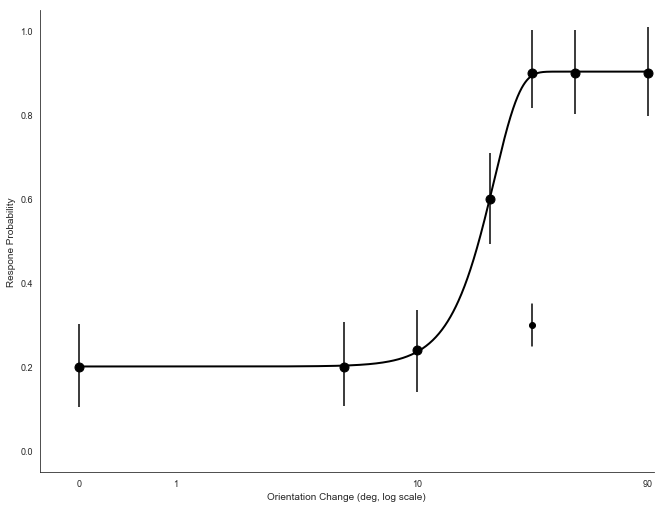

In [93]:
savepath= '/home/dougo/dropbox/BrainTV-BehaviorDevelopment/Phase 4 Planning/Dynamic Routing/full_proposal/Figures/behavior_schematic'
fname = 'simulated_psychometric'

x = [0,   5,   10,   20,  30,  45,  90]
y = [0.2, 0.2, 0.24, 0.6, 0.9, 0.9, 0.9]
CI = [(y-0.1+0.01*np.random.randn(),y+0.1+0.01*np.random.randn()) for y in y]
fig,ax=plt.subplots(figsize=(6,6))
plot_psychometric(
    x,
    y,
    ax=ax,
    logscale=True,
    xlim=[0,90],
    minval=0.4,
    xticks=[0,1,10,90],
    initial_guess=(np.log10(20), 0.9, 0.2, 0.2),
    CI=CI,
)
ax.set_xlabel('Orientation Change (deg, log scale)')
sns.despine()
ax.set_xlim(np.log10(0.275),np.log10(95))

ax.plot(np.log10(30),0.3,'ok')
ax.plot([np.log10(30), np.log10(30)],[0.25,0.35],marker=None,color='black')

vbp.save_figure(fig,os.path.join(savepath,fname),formats=['.png','.pdf'])

In [ ]:

fig.